In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules
from wordcloud import WordCloud
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Fixing the random seed
np.random.seed(42)
random.seed(42)

In [3]:
addresses = pd.read_csv('DATA/tbl_addresses.csv')
customer_acc = pd.read_csv('DATA/tbl_customer_accounts.csv')
customer_rew = pd.read_csv('DATA/tbl_customer_reviews.csv')
customers = pd.read_csv('DATA/tbl_customers.csv')
reviews = pd.read_csv('DATA/tbl_labelled_reviews.csv')
orders = pd.read_csv('DATA/tbl_orders.csv')
products = pd.read_csv('DATA/tbl_products.csv')

# Preparing the data


In [5]:
customers['job_type'] = customers['job_type'].fillna('Unknown')
customers['email_provider'] = customers['email_provider'].fillna('Unknown')
customers['flag_phone_provided'] = customers['flag_phone_provided'].fillna(0).astype(bool)


In [6]:
customer_acc['activation_date'] = pd.to_datetime(customer_acc['activation_date'])


In [10]:
def fill_missing_location_data(addresses):
    postal_code_map = addresses.dropna(subset=['postal_code', 'district', 'region']) \
        .groupby('postal_code').agg({
        'district': lambda x: x.value_counts().index[0],
        'region': lambda x: x.value_counts().index[0]
    }).to_dict('index')

    def fill_from_map(row):
        if pd.isnull(row['district']) or pd.isnull(row['region']):
            mapped_values = postal_code_map.get(row['postal_code'], {})
            row['district'] = mapped_values.get('district', row['district'])
            row['region'] = mapped_values.get('region', row['region'])
        return row

    df = addresses.apply(fill_from_map, axis=1)

    imputer = SimpleImputer(strategy='most_frequent')
    df[['district', 'region']] = imputer.fit_transform(df[['district', 'region']])

    return df

df = fill_missing_location_data(addresses)

print("missing values:")
print(df[['postal_code', 'district', 'region']].isnull().sum())
addresses = df

missing values:
postal_code    49
district        0
region          0
dtype: int64


In [12]:
def fill_missing_postal_codes(df):
    district_region_to_postal = df.dropna().groupby(['district', 'region'])['postal_code'].agg(
        lambda x: x.value_counts().index[0]
    ).to_dict()

    df['postal_code'] = df.apply(
        lambda row: district_region_to_postal.get((row['district'], row['region']), row['postal_code'])
        if pd.isnull(row['postal_code']) else row['postal_code'],
        axis=1
    )

    if df['postal_code'].isnull().sum() > 0:
        df['postal_code_num'] = pd.to_numeric(df['postal_code'], errors='coerce')

        features_for_imputation = ['postal_code_num', 'latitude', 'longitude']  # предполагаем, что у нас есть координаты

        imputer = KNNImputer(n_neighbors=5)
        df[features_for_imputation] = imputer.fit_transform(df[features_for_imputation])

        df['postal_code'] = df['postal_code_num'].apply(lambda x: f"{x:05.0f}" if not pd.isnull(x) else None)
        df.drop('postal_code_num', axis=1, inplace=True)

    df['postal_code'].fillna('UNKNOWN', inplace=True)

    return df

df = fill_missing_postal_codes(df)
orders['purchase_datetime'] = pd.to_datetime(orders['purchase_datetime'])


/var/folders/9r/54xgf7zn6kddvpnb0lh4dgmc0000gn/T/ipykernel_92233/3605204438.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['postal_code'].fillna('UNKNOWN', inplace=True)


# Customer Focus

# RFM

In [13]:

df = customers.merge(customer_acc, on='customer_id')
df = df.merge(orders, on='customer_id')

last_purchase_date = df['purchase_datetime'].max()

# Recency
df['last_purchase_date'] = pd.to_datetime(df['purchase_datetime'])
df['Recency'] = (last_purchase_date - df['last_purchase_date']).dt.days

# Frequency
frequency = df.groupby('customer_id')['order_id'].count().reset_index()
frequency.columns = ['customer_id', 'Frequency']
df = df.merge(frequency, on='customer_id')

# Monetary
df['Monetary'] = df['gross_price']
monetary = df.groupby('customer_id')['Monetary'].sum().reset_index()
df = df.merge(monetary, on='customer_id', suffixes=('', '_total'))

# Calculate RFM scores
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(df['Recency'], q=4, labels=r_labels)
f_labels = range(1, 5)
f_quartiles = pd.qcut(df['Frequency'], q=4, labels=f_labels)
m_labels = range(1, 5)
m_quartiles = pd.qcut(df['Monetary_total'], q=4, labels=m_labels)

df['R'] = r_quartiles
df['F'] = f_quartiles
df['M'] = m_quartiles

df['RFM_Score'] = df['R'].astype(str) + df['F'].astype(str) + df['M'].astype(str)

high_value = df[df['RFM_Score'].isin(['444', '434', '443', '433', '442', '432'])]

high_value[['customer_id', 'RFM_Score', 'Recency', 'Frequency', 'Monetary_total']].head()

high_value.to_csv('DATA/high_value_customers.csv', index=False)

# CHURN

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

df = pd.read_csv('DATA/high_value_customers.csv')

df['Churn'] = df['Recency'] > 60

features = ['Recency', 'Frequency', 'Monetary', 'R', 'F', 'M']
categorical_features = ['gender', 'job_type', 'loyalty_type']
df_encoded = pd.get_dummies(df, columns=categorical_features)
features += [col for col in df_encoded.columns if col.startswith(tuple(categorical_features))]

X = df_encoded[features]
y = df_encoded['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 5]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters found by GridSearchCV:")
print(grid_search.best_params_)

best_rf_model = grid_search.best_estimator_

y_pred = best_rf_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

churn_prob = best_rf_model.predict_proba(X_scaled)[:, 1]
df['Churn_Probability'] = churn_prob

at_risk = df[df['Churn_Probability'] > 0.7]

print(f"\nNumber of high-value customers at risk of churning: {len(at_risk)}")
print(at_risk[['customer_id', 'RFM_Score', 'Churn_Probability']].head())

feature_importance = pd.DataFrame({'feature': features, 'importance': best_rf_model.feature_importances_})
print("\nFeature Importance:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

at_risk.to_csv('DATA/high_value_at_risk.csv', index=False)


Best parameters found by GridSearchCV:
{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     15866
        True       1.00      1.00      1.00      7582

    accuracy                           1.00     23448
   macro avg       1.00      1.00      1.00     23448
weighted avg       1.00      1.00      1.00     23448


Confusion Matrix:
[[15866     0]
 [    0  7582]]

Number of high-value customers at risk of churning: 38234
    customer_id  RFM_Score  Churn_Probability
83       784295        433            0.85631
84       784295        433            0.85631
85       784295        433            0.85631
86       784295        433            0.85631
87       784295        433            0.85631

Feature Importance:
                          feature  importance
0                         Recency    0.921496
1                       Fre

In [17]:
rfm = pd.read_csv('DATA/high_value_customers.csv')
total_customers = rfm['customer_id'].nunique()

print(f"The number of uniqie  customer_id: {total_customers}")

The number of uniqie  customer_id: 8080


In [15]:
churn = pd.read_csv('DATA/high_value_at_risk.csv')
total_at_risk = churn['customer_id'].nunique()

print(f"The number of uniqie  customer_id: {total_at_risk}")

The number of uniqie  customer_id: 4757


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


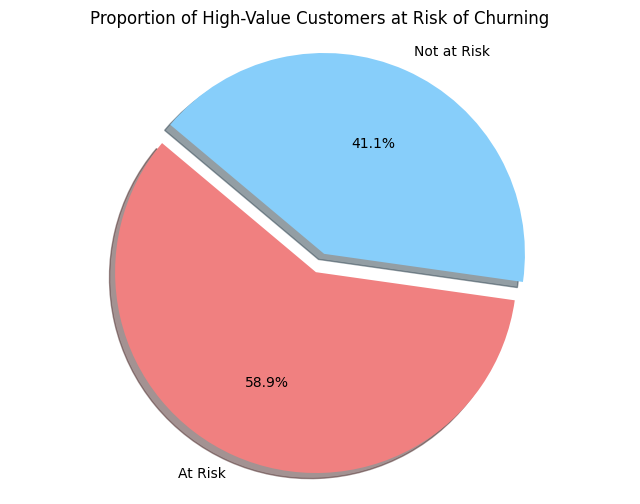

In [18]:

not_at_risk = total_customers - total_at_risk

labels = 'At Risk', 'Not at Risk'
sizes = [total_at_risk, not_at_risk]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)  

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Proportion of High-Value Customers at Risk of Churning')
plt.axis('equal')
plt.show()


#  Product Focus: Increase the profit by a marketing campaign for product cross-selling;

In [20]:
pd.set_option('display.max_colwidth', None)

transactions = orders.groupby('order_id')['product_id'].apply(list).reset_index()

te = TransactionEncoder()
te_ary = te.fit(transactions['product_id']).transform(transactions['product_id'])
df = pd.DataFrame(te_ary, columns=te.columns_)

min_support = 0.0025 
frequent_itemsets = fpgrowth(df, min_support=min_support, use_colnames=True)
print(f"Frequent itemsets with FP-Growth:")
print(frequent_itemsets)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
print(f"Association rules with FP-Growth:")
print(rules)

top_rules = rules.sort_values('lift', ascending=False).head(10)
print(top_rules)

cross_selling_offers = top_rules[['antecedents', 'consequents', 'lift']].copy()
cross_selling_offers['antecedents'] = cross_selling_offers['antecedents'].apply(lambda x: ', '.join(map(str, x)))
cross_selling_offers['consequents'] = cross_selling_offers['consequents'].apply(lambda x: ', '.join(map(str, x)))
cross_selling_offers['offer'] = cross_selling_offers.apply(
    lambda x: f"When purchasing {x['antecedents']} also recommend {x['consequents']}", axis=1
)
print(cross_selling_offers)


Frequent itemsets with FP-Growth:
      support                        itemsets
0    0.003209                      (34916056)
1    0.004559                      (35874006)
2    0.006875                      (31618300)
3    0.004970                      (31618321)
4    0.004688                      (32988382)
..        ...                             ...
155  0.002614  (31618300, 31618405, 34129942)
156  0.003445            (31618300, 34129942)
157  0.003886            (32842551, 32079103)
158  0.003284            (32079082, 32842551)
159  0.002980  (32079082, 32842551, 32079103)

[160 rows x 2 columns]
Association rules with FP-Growth:
             antecedents           consequents  antecedent support  \
0             (31618321)            (31618300)            0.004970   
1             (31618300)            (31618321)            0.006875   
2             (31618321)            (31618405)            0.004970   
3             (31618405)            (31618321)            0.006366   
4     

/Users/diaskarimov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/diaskarimov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/diaskarimov/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


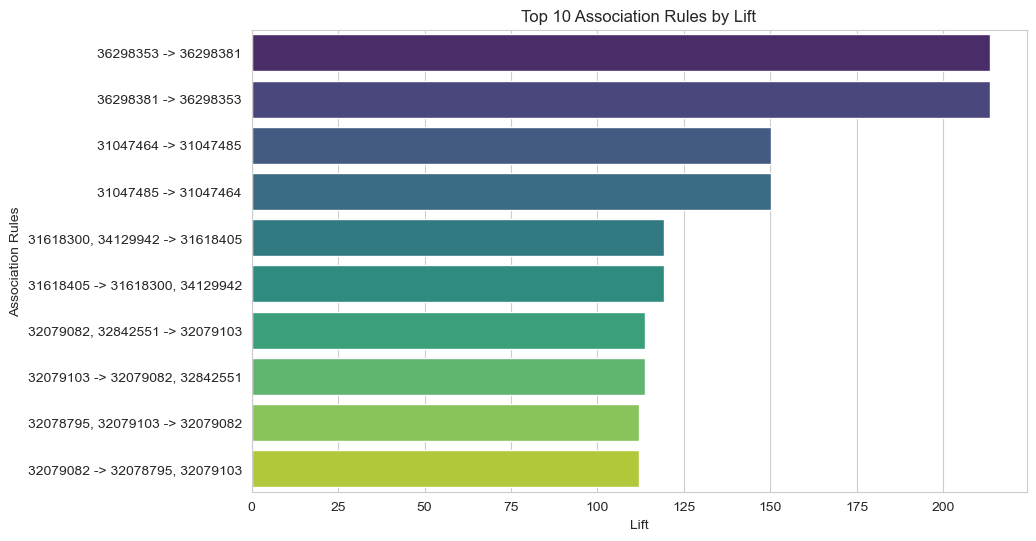

In [21]:
top_rules = rules.nlargest(10, 'lift')
plt.figure(figsize=(10, 6))
sns.barplot(x=top_rules['lift'], y=top_rules.apply(lambda x: ', '.join(map(str, x['antecedents'])) + ' -> ' + ', '.join(map(str, x['consequents'])), axis=1), palette='viridis')
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Lift')
plt.ylabel('Association Rules')
plt.show()


# Feedback Focus: Address detractor and promoter customers with a loyal engagement marketing campaign to reduce the negative impact of detractors and to incentive the positive effect of promoters.

In [22]:
promoters = reviews[reviews['sentiment_label'] == 'positive'].shape[0]
detractors = reviews[reviews['sentiment_label'] == 'negative'].shape[0]
neutral_count = reviews[reviews['sentiment_label'] == 'neutral'].shape[0]

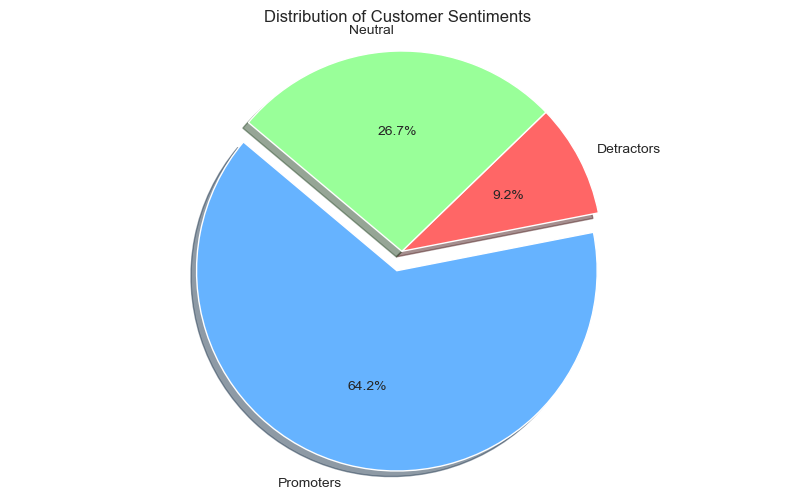

In [23]:
labels = 'Promoters', 'Detractors', 'Neutral'
sizes = [promoters, detractors, neutral_count]
colors = ['#66b3ff', '#ff6666', '#99ff99']
explode = (0.1, 0, 0)  
plt.figure(figsize=(10, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=140)
plt.title('Distribution of Customer Sentiments')
plt.axis('equal')  
plt.show()

For better prediction we should increase n_estimators

In [20]:
reviews['review_text'] = reviews['review_text'].str.lower().str.replace(r'[^\w\s]', '', regex=True)

vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(reviews['review_text'])
y = reviews['sentiment_label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.93      0.53      0.67      8523
     neutral       0.86      0.58      0.69     24636
    positive       0.81      0.98      0.89     59390

    accuracy                           0.83     92549
   macro avg       0.87      0.69      0.75     92549
weighted avg       0.84      0.83      0.82     92549




n_estimator = 500

              precision    recall  f1-score   support

    negative       0.93      0.52      0.67      8523
     neutral       0.88      0.57      0.69     24636
    positive       0.81      0.98      0.89     59390

    accuracy                           0.83     92549
